In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram

import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pprint import pprint
from IPython.display import Audio
from scipy.io import wavfile

from bark.bark import SAMPLE_RATE, generate_audio, preload_models

In [2]:
def save_history(basepath: str, audio_array: np.ndarray, prompt: str, generation_data: list):
  np.savez(f"{basepath}.npz", semantic_prompt=generation_data[0], coarse_prompt=generation_data[1], fine_prompt=generation_data[2])
  with open(f"{basepath}.txt", "w", encoding="utf-8") as fp: fp.write(prompt)
  wavfile.write(f"{basepath}.wav", SAMPLE_RATE, audio_array)

def load_history(filepath: str):
  return np.load(filepath)

def load_voice(filepath: str):
  sample_rate, audio_array = wavfile.read(filepath)
  return audio_array

def display_spectrogram(audio_array: np.ndarray):
  plt.specgram(audio_array, NFFT=400, Fs=SAMPLE_RATE)
  plt.show()

In [3]:
NUM_EPOCHS = 1
NUM_STEPS = 10000

BATCH_SIZE = 4

DURATION = 3000
SHIFT = 10

EMBEDDING_DIM = int(DURATION * SAMPLE_RATE / 1000)

In [4]:
class VoiceDataset(Dataset):
  def __init__(self, directory, embedding_dim = EMBEDDING_DIM):
    super().__init__()
    self.k = 1
    self.num_mels = 64
    self.population = 0
    self.length = 0
    self.embedding_dim = embedding_dim
    self.voices = []
    self.base_map = {}
    self.ms = MelSpectrogram(SAMPLE_RATE, n_mels=self.num_mels)
    for filename in os.listdir(directory):
      if not filename.endswith(".wav"): continue
      self.voices.append([])
      self.population += 1
      folder_name = filename.split(".wav")[0]
      self.base_map[folder_name] = self.population
      for fn in os.listdir(f"./data/bark/{folder_name}"):
        if not fn.endswith(".wav"): continue
        waveform, sample_rate = torchaudio.load(f"./data/bark/{folder_name}/{fn}")
        self.voices[-1].append(waveform.view(-1, 1))
        self.length += 1

  def __getitem__(self, _):
    samples, targets, labels = [], [], torch.zeros(len(self.voices) * self.k)
    r_index = random.randint(0, len(self.voices) - 1)
    labels[r_index] = 1
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(self.ms(s[r:r + self.embedding_dim].view(1, -1)).numpy())
      for t in random.choices(self.voices[r_index], k=self.k):
        r = random.randint(0, len(t) - self.embedding_dim)
        targets.append(self.ms(t[r:r + self.embedding_dim].view(1, -1)).numpy())
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    return samples, targets, labels

  def get_selected(self, target):
    samples, targets = [], []
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(self.ms(s[r:r + self.embedding_dim].view(1, -1)).numpy())
        r = random.randint(0, len(target) - self.embedding_dim)
        targets.append(self.ms(torch.tensor(target[r:r + self.embedding_dim].view(1, -1)).float()).numpy())
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    return samples, targets

  def __len__(self): return self.length

In [5]:
dataset = VoiceDataset("./data/bark")
torch.save(dataset, "./checkpoints/bark_dataset.pt")

In [6]:
dataset = torch.load("./checkpoints/bark_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True)

In [7]:
class Judge(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq1 = nn.Sequential(
      nn.Conv2d(1, 64, 4, 2, 1),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(4),
      nn.ReLU(True),
      nn.Conv2d(64, 128, 2),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(2),
      nn.ReLU(True),
      nn.Conv2d(128, 256, 2),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(2),
      nn.ReLU(True),
      nn.Flatten(),
      nn.Dropout(0.3)
    )
    self.seq2 = nn.Sequential(
      nn.Linear(256 * 20, 256),
      nn.ReLU(True),
      nn.Linear(256, 64),
      nn.ReLU(True),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )

  def forward(self, sample, target):
    outputs1 = self.seq1(sample.view(sample.size(0), 1, sample.size(1), sample.size(2)))
    outputs2 = self.seq1(target.view(sample.size(0), 1, sample.size(1), sample.size(2)))
    outputs = self.seq2(torch.cat((outputs1, outputs2), dim=1))
    return outputs

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.judge = Judge()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, samples, targets):
    outputs = []
    for s, t in zip(samples, targets): outputs.append(self.judge(s, t))
    outputs = torch.cat(tuple(outputs), dim=1).permute(1, 0)
    outputs = self.softmax(outputs)
    return outputs

In [8]:
samples, targets, labels = next(iter(dataloader))
model = Model()
loss_fn = nn.CrossEntropyLoss()
outputs = model(samples, targets)
print(samples.shape, targets.shape)
print(outputs)
print(labels)
print(loss_fn(outputs, labels))

torch.Size([4, 10, 64, 361]) torch.Size([4, 10, 64, 361])
tensor([[0.0974, 0.1074, 0.1014, 0.0988, 0.1005, 0.0981, 0.1015, 0.1005, 0.0960,
         0.0985],
        [0.0993, 0.1009, 0.1069, 0.1004, 0.0980, 0.0999, 0.0991, 0.0974, 0.0985,
         0.0997],
        [0.0978, 0.0995, 0.1018, 0.1001, 0.0992, 0.1045, 0.0992, 0.0973, 0.1007,
         0.1000],
        [0.0991, 0.0942, 0.0980, 0.1015, 0.1029, 0.0987, 0.1010, 0.1016, 0.1022,
         0.1008]], grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor(2.3032, grad_fn=<DivBackward1>)


100/10000:	2.3018
200/10000:	2.3025
300/10000:	2.3019
400/10000:	2.3015
500/10000:	2.3025
600/10000:	2.3008
700/10000:	2.3004
800/10000:	2.3014
900/10000:	2.3010
1000/10000:	2.3002
1100/10000:	2.2991
1200/10000:	2.2954
1300/10000:	2.2967
1400/10000:	2.2969
1500/10000:	2.2986
1600/10000:	2.2958
1700/10000:	2.2968
1800/10000:	2.2960
1900/10000:	2.2957
2000/10000:	2.2958
2100/10000:	2.2971
2200/10000:	2.2955
2300/10000:	2.2928
2400/10000:	2.2950
2500/10000:	2.2955
2600/10000:	2.2930
2700/10000:	2.2938
2800/10000:	2.2956
2900/10000:	2.2925
3000/10000:	2.2938
3100/10000:	2.2924
3200/10000:	2.2921
3300/10000:	2.2898
3400/10000:	2.2907
3500/10000:	2.2911
3600/10000:	2.2915
3700/10000:	2.2896
3800/10000:	2.2870
3900/10000:	2.2875
4000/10000:	2.2885
4100/10000:	2.2873
4200/10000:	2.2868
4300/10000:	2.2895
4400/10000:	2.2866
4500/10000:	2.2892
4600/10000:	2.2888
4700/10000:	2.2862
4800/10000:	2.2857
4900/10000:	2.2860
5000/10000:	2.2850
5100/10000:	2.2808
5200/10000:	2.2867
5300/10000:	2.2854
54

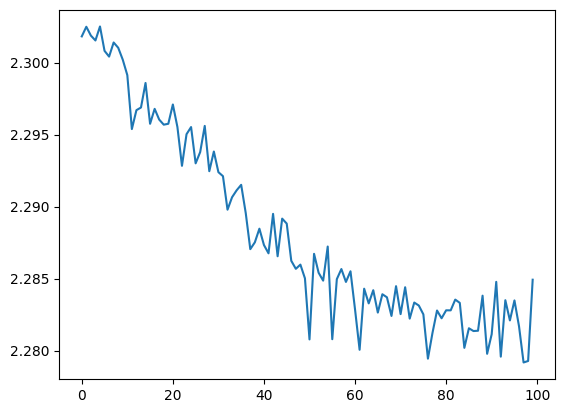

In [10]:
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model()
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
losses = []
display_losses = []

model.train()

if device == "cuda": model.cuda()
for step in range(1, NUM_STEPS + 1):
  optimizer.zero_grad()
  samples, targets, labels = next(iter(dataloader))
  outputs = model(samples.to(device), targets.to(device))
  loss = loss_fn(outputs.to(device), labels.to(device))
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  if step % 100 == 0:
    display_losses.append(np.mean(losses))
    print(f"{step}/{NUM_STEPS}:\t{display_losses[-1]:.4f}")
    losses = []
print("Training Ended!")
plt.plot(display_losses)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Kui\AppData\Local\Temp\ipykernel_31760\696373266.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets.append(self.ms(torch.tensor(target[r:r + self.embedding_dim].view(1, -1)).float()).numpy())


array([[0.09986919, 0.09986719, 0.09986752, 0.09986719, 0.09986793,
        0.09986766, 0.10027472, 0.09987074, 0.10047197, 0.1001759 ]])

array([ 22.,   0.,   3.,   0.,  12.,   4., 287.,  48., 304., 320.])

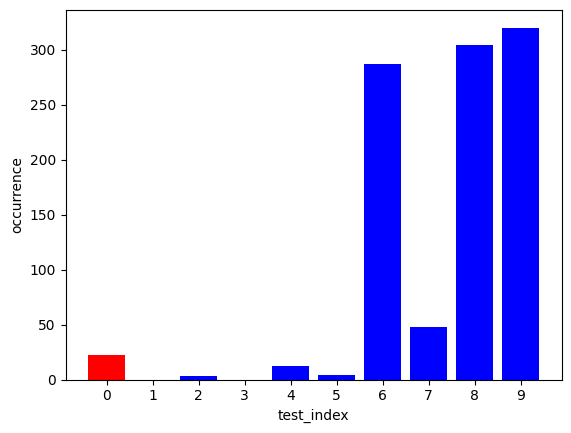

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.09985896, 0.09985873, 0.09985875, 0.09985874, 0.09985929,
        0.0998602 , 0.10025968, 0.09986295, 0.10034575, 0.10037695]])

array([ 34.,   0.,   1.,   0.,  24.,   4., 259., 108., 282., 288.])

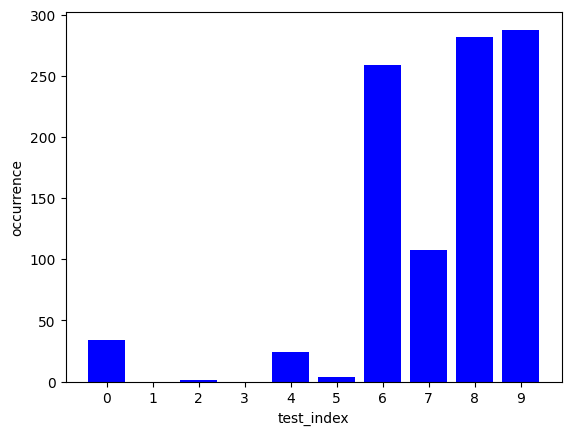

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.09996717, 0.09996709, 0.0999671 , 0.09996709, 0.09996716,
        0.09996711, 0.10013687, 0.09996789, 0.10006746, 0.10002505]])

array([ 18.,   0.,   2.,   3.,  16.,   4., 289.,  84., 308., 276.])

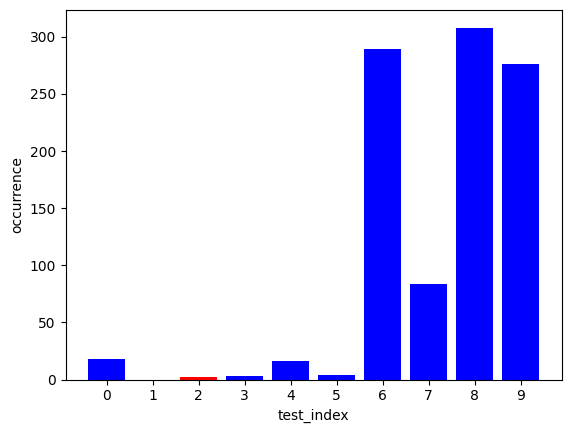

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.09999933, 0.0999993 , 0.0999993 , 0.0999993 , 0.09999935,
        0.0999993 , 0.10000089, 0.09999944, 0.10000243, 0.10000137]])

array([ 28.,   0.,   3.,   1.,  31.,   3., 299.,  90., 262., 283.])

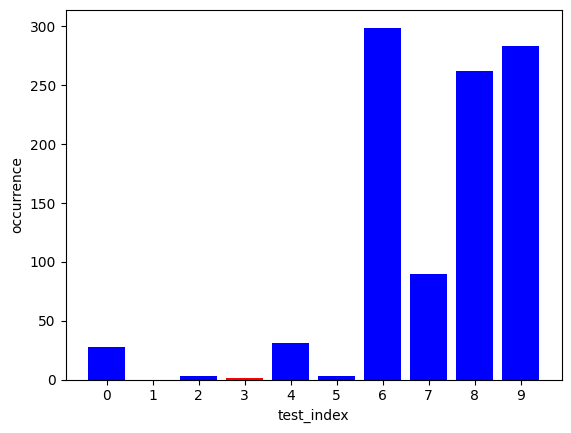

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.09999856, 0.09999851, 0.09999851, 0.09999851, 0.09999854,
        0.09999852, 0.1000014 , 0.0999987 , 0.10000886, 0.0999999 ]])

array([ 23.,   0.,   1.,   1.,  11.,   5., 299.,  89., 294., 277.])

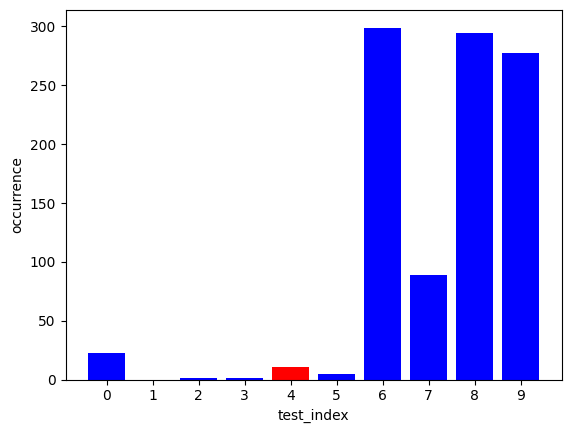

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.09998132, 0.09998121, 0.09998124, 0.09998121, 0.09998126,
        0.09998124, 0.10006772, 0.0999818 , 0.10002291, 0.10004009]])

array([ 32.,   0.,   4.,   1.,  24.,   5., 284.,  79., 288., 283.])

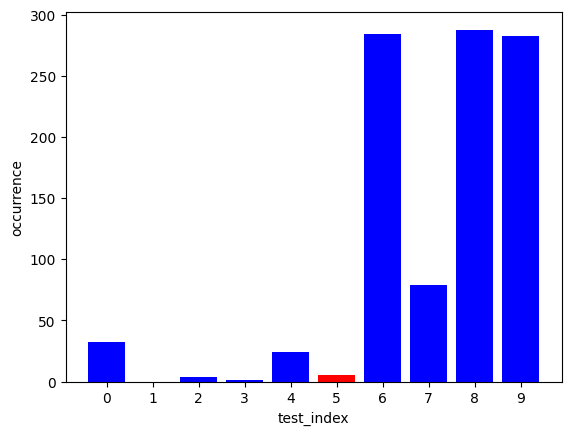

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07288059, 0.07102754, 0.07155484, 0.07105055, 0.07229415,
        0.07273166, 0.15097834, 0.07697229, 0.1698466 , 0.17066346]])

array([  3.,   0.,   0.,   0.,   2.,   3., 224.,   3., 386., 379.])

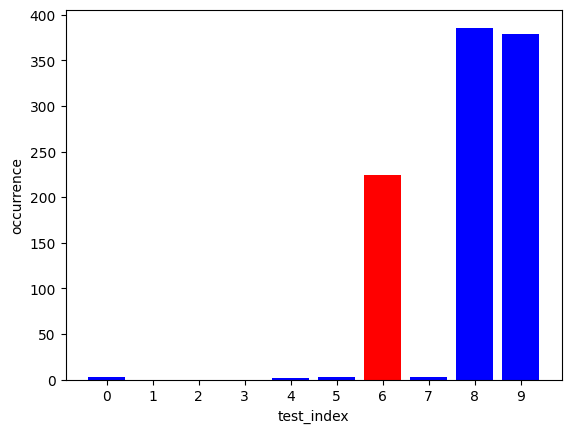

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.0999999 , 0.09999989, 0.09999989, 0.09999989, 0.0999999 ,
        0.09999989, 0.10000025, 0.09999996, 0.1000002 , 0.10000025]])

array([ 21.,   0.,   0.,   1.,  17.,   1., 310., 110., 278., 262.])

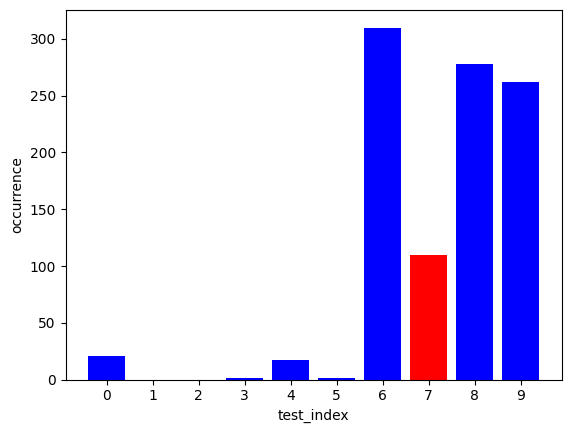

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.0703689 , 0.06786057, 0.0688745 , 0.06786354, 0.07027045,
        0.06994499, 0.1460463 , 0.07453219, 0.1815546 , 0.18268396]])

array([  2.,   0.,   3.,   0.,   5.,   3., 110.,   8., 397., 472.])

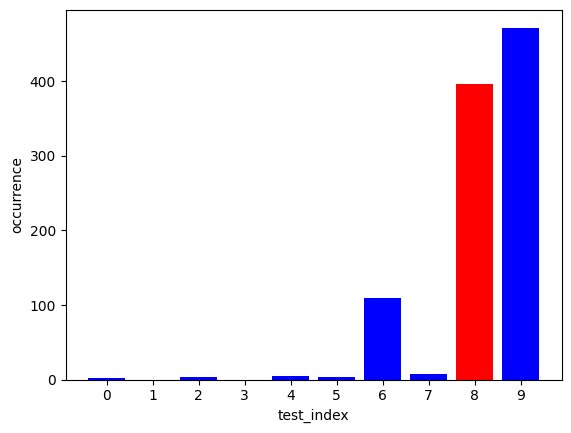

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.08599815, 0.08572587, 0.08604447, 0.0857259 , 0.08620408,
        0.08610981, 0.11301924, 0.08650781, 0.14252942, 0.14213525]])

array([  1.,   0.,   2.,   0.,   2.,   2., 165.,   4., 429., 395.])

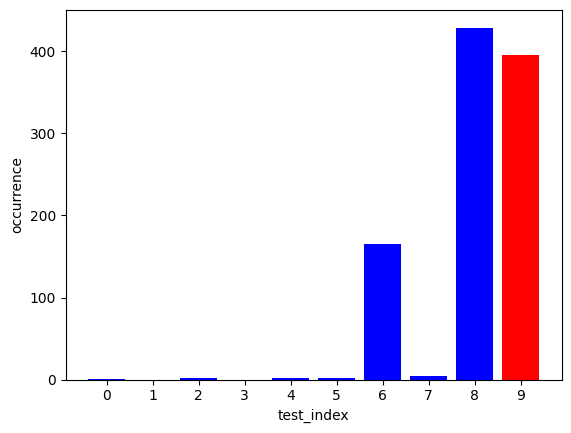

In [12]:
num_validation = 1000
test_cases = ["man-1", "man-2", "man-3", "woman-1", "woman-2", "woman-3"]
test_cases = ["man-1", "man-2", "man-3", "man-4", "man-5", "woman-1", "woman-2", "woman-3", "woman-4", "woman-5"]

with torch.no_grad():
  for test_index in range(len(dataset.voices)):
    colors = ["b" if i != test_index else "r" for i in range(len(dataset.voices))]
    avg = np.zeros((1, len(dataset.voices)))
    occurrences = np.zeros(len(dataset.voices))
    for i in tqdm(range(num_validation)):
      t, _ = torchaudio.load(f"./data/bark/{test_cases[test_index]}.wav")
      samples, targets = dataset.get_selected(t.view(-1, 1))
      outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
      avg += outputs.cpu().numpy()
      occurrences[outputs.cpu().numpy().argmax()] += 1
    display(avg / num_validation)
    display(occurrences)
    plt.bar(np.arange(len(dataset.voices)), occurrences, color=colors)
    plt.xticks(range(len(dataset.voices)))
    plt.xlabel("test_index")
    plt.ylabel("occurrence")
    plt.show()
  # display(Audio(samples[0], rate=SAMPLE_RATE))
  # display(Audio(targets[0], rate=SAMPLE_RATE))
  # display(Audio(samples[1], rate=SAMPLE_RATE))
  # display(Audio(targets[1], rate=SAMPLE_RATE))
  # display(Audio(samples[2], rate=SAMPLE_RATE))
  # display(Audio(targets[2], rate=SAMPLE_RATE))

In [8]:
def generate(basename, raw_prompt, index):
  basepath = "./data/bark/"
  text_prompt = re.sub(r"\s\s+", " ", re.sub(r"[\t\n]", "", raw_prompt)).strip()
  print(f"{basename}: prompt-{index}")
  audio_array, generation_data = generate_audio(text_prompt, basename)
  if basename not in os.listdir(basepath): os.mkdir(f"{basepath}/{basename}")
  save_history(f"{basepath}/{basename}/prompt-{index}", audio_array, text_prompt, generation_data)

In [ ]:
preload_models(use_smaller_models=True)

In [9]:
raw_prompts = [
  "A pessimist is one who makes difficulties of his opportunities and an optimist is one who makes opportunities of his difficulties.",
  "Don't judge each day by the harvest you reap but by the seeds that you plant.",
  "Challenges are what make life interesting and overcoming them is what makes life meaningful.",
  "Happiness lies not in the mere possession of money; it lies in the joy of achievement, in the thrill of creative effort.",
  "I disapprove of what you say, but I will defend to the death your right to say it.",
  "If I looked compared to others far, is because I stand on giant's shoulder.",
  "Never argue with stupid people, they will drag you down to their level and then beat you with experience.",
  "The greatest glory in living lies not in never falling, but in rising every time we fall.",
  "When you look into the abyss, the abyss also looks into you.",
  "Whoever fights monsters should see to it that in the process he does not become a monster."
]

basename = "woman-2"

for i, raw_prompt in enumerate(raw_prompts):
  generate(basename, raw_prompt, i)

woman-2: prompt-0
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 26/26 [00:25<00:00,  1.02it/s]


woman-2: prompt-1
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


woman-2: prompt-2
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 26/26 [00:25<00:00,  1.00it/s]


woman-2: prompt-3
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


woman-2: prompt-4
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


woman-2: prompt-5
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


woman-2: prompt-6
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


woman-2: prompt-7
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


woman-2: prompt-8
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


woman-2: prompt-9
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]
